In [3]:
import pandas as pd
import numpy as np
import random
import gc
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import recall_score, auc, accuracy_score, f1_score, precision_score, classification_report
from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_datetime64_any_dtype as is_datetime
import missingno as msno

In [4]:
data = pd.read_csv('./data.csv')

In [5]:
pd.set_option('display.max_columns', None)
data.drop(['user_id','ip'], axis=1, inplace=True)
# data.drop(['user_id','ip','game_pay_num', 'chmoney_pay_num'], axis=1, inplace=True)
data = data.select_dtypes(include='number')
print(data.shape)
data.head()

(642751, 42)


,role_level,net_type,u1,u2,u3,u4,u5,u6,g7,g8,g9,g10,is_create_role,is_create_no,platform,user_type,user_flag,mobile,game_pay_num,chmoney_pay_num,server_sum,rollsrv,m1,m2,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,is_pay,s1,s2,s3,s4,s5,s6,s7
0,4,0.0,1,1,1,1,0.0,0.0,136657,151468,129869,1813367,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2815759.0,16429.0,5270.0,5413.0,5206.0,133.462657,0.770520,0.027391,1021.0,1209.0,1033.0,0.0,0.009060,0.038564,0.035737,0.040087,0.193738,0.223351,0.198425
1,4,0.0,1,1,1,1,0.0,0.0,136657,151468,129869,1813367,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2815759.0,16429.0,5270.0,5413.0,5206.0,133.462657,0.770520,0.027391,1021.0,1209.0,1033.0,0.0,0.009060,0.038564,0.035737,0.040087,0.193738,0.223351,0.198425
2,0,0.0,1,1,1,1,0.0,0.0,2799,2883,2463,20322,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,32322.0,240.0,90.0,92.0,85.0,34.900000,0.029500,0.000000,45.0,55.0,49.0,0.0,0.011810,0.032154,0.031911,0.034511,0.500000,0.597826,0.576471
3,73,1.0,1,1,1,1,0.0,0.0,9564,10386,9338,222150,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,408350.0,5562.0,723.0,737.0,717.0,60.310859,0.528357,0.191837,117.0,151.0,123.0,0.0,0.025037,0.075596,0.070961,0.076783,0.161826,0.204885,0.171548
4,226,2.0,1,1,1,1,0.0,0.0,17669,19404,12415,429231,1.0,1.0,1.0,1.0,1.0,0.0,3.0,0.0,1.0,0.0,1.0,1577912.0,3730.0,760.0,772.0,680.0,64.489008,3.191399,0.060858,196.0,260.0,162.0,0.0,0.008690,0.043013,0.039786,0.054772,0.257895,0.336788,0.238235


In [257]:
# data['net_w'].value_counts()
# data['net_w'].replace('WIFI', 'wifi', inplace=True)
# data['net_w'].replace('4G', '4g', inplace=True)
# data['net_w'].replace(['未知网络','none','notReachable','other','LTE'],'unknown', inplace=True)
# data['net_w'].replace(['2.75G EDGE','2G'], '2g', inplace=True)
# data['net_w'].replace(['3.5g', '3G', '3.5G HSDPA'], '3g', inplace=True)

In [6]:
data['is_pay'].value_counts()

0.0    606137
1.0     36614
Name: is_pay, dtype: int64

In [7]:
data['game_pay_num'].value_counts()

0.0      395800
1.0       26537
2.0        7741
3.0        3621
4.0        2207
          ...  
62.0          1
97.0          1
115.0         1
53.0          1
126.0         1
Name: game_pay_num, Length: 84, dtype: int64

In [8]:
data_po = data[data['is_pay'] == 1]
data_ng= data[data['is_pay'] == 0]

In [261]:
# # 修改net_w字段,one-hot
# data = pd.get_dummies(data, columns=['net_w'], prefix='net')
# le = LabelEncoder()
# data['net_type'] = le.fit_transform(data['net_type'])
# categorical_features = ['p_model', 'sys_ver', 'net_w', 'sdk_no', 'city']


In [9]:
data_ng.dropna(subset=['game_pay_num','p1','s7'], inplace=True)

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
data_ng.shape

(420090, 42)

In [11]:
data_sample = data_ng.sample(n=60000)

In [12]:
fit_data = pd.concat([data_sample, data_po])

In [13]:
fit_data['is_pay'].value_counts()

0.0    60000
1.0    36614
Name: is_pay, dtype: int64

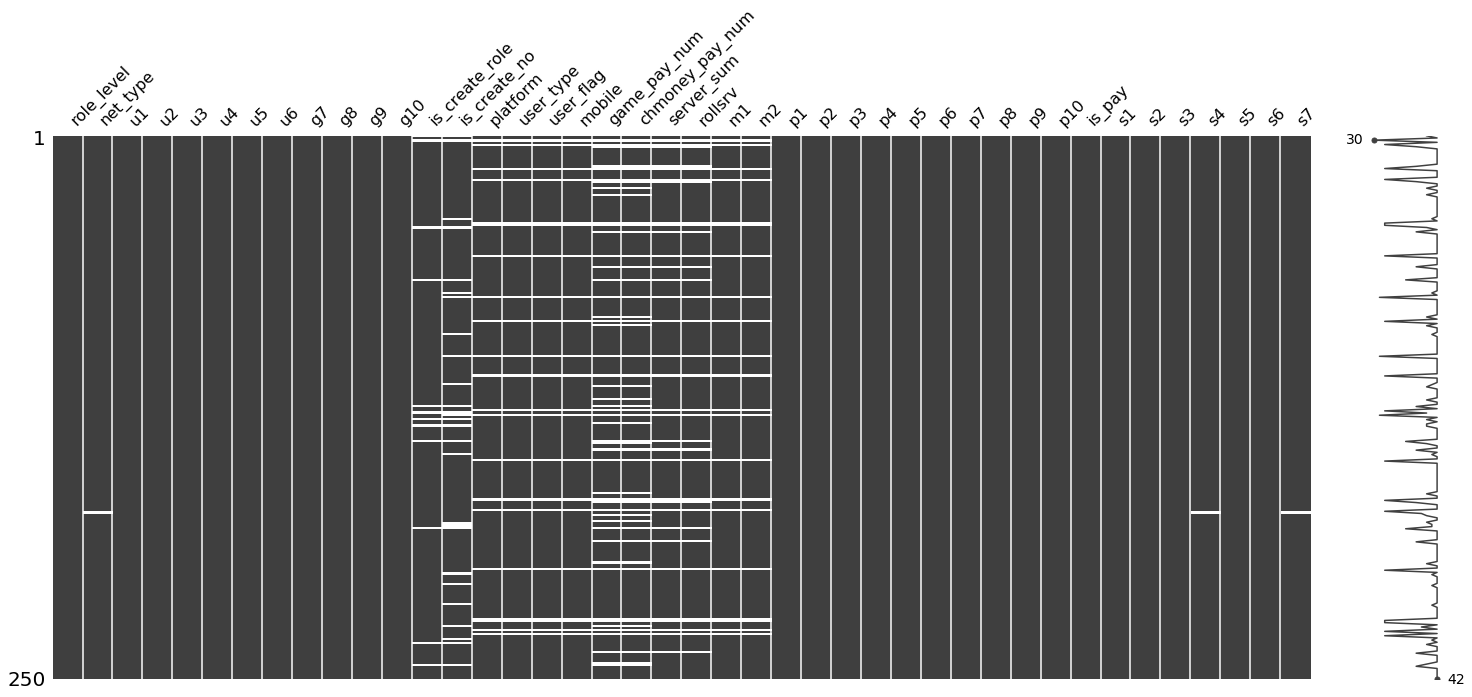

In [14]:
msno.matrix(fit_data.sample(250))

In [15]:
print(fit_data.shape)
fit_data.head()

(96614, 42)


,role_level,net_type,u1,u2,u3,u4,u5,u6,g7,g8,g9,g10,is_create_role,is_create_no,platform,user_type,user_flag,mobile,game_pay_num,chmoney_pay_num,server_sum,rollsrv,m1,m2,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,is_pay,s1,s2,s3,s4,s5,s6,s7
605642,1,0.0,34,1,1,3,2.97,0.09,30747,34456,27769,769750,1.0,1.0,2.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,361733.0,9366.0,2011.0,2069.0,1970.0,173.605168,0.476182,0.000000,428.0,516.0,427.0,0.0,0.012168,0.065405,0.060048,0.070942,0.212829,0.249396,0.216751
175956,0,1.0,1,1,1,1,0.00,0.00,29848,32547,28829,336843,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,457535.0,4827.0,1304.0,1339.0,1277.0,139.176300,0.476462,0.616946,375.0,426.0,357.0,0.0,0.014330,0.043688,0.041141,0.044296,0.287577,0.318148,0.279561
152401,0,0.0,1,1,1,1,0.00,0.00,1118,1199,1116,3749,1.0,1.0,1.0,18.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,2218.0,40.0,24.0,1.0,24.0,40.050000,0.000000,0.000000,20.0,40.0,20.0,0.0,0.010670,0.021467,0.000834,0.021505,0.833333,40.000000,0.833333
37313,0,1.0,1,1,1,1,0.00,0.00,16513,17215,16746,151916,1.0,1.0,1.0,13.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,307375.0,4132.0,570.0,584.0,576.0,76.887222,0.000000,0.000000,188.0,214.0,196.0,0.0,0.027199,0.034518,0.033924,0.034396,0.329825,0.366438,0.340278
216295,0,1.0,5,1,1,2,23.75,4.75,16513,17215,16746,151916,0.0,0.0,1.0,13.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,307375.0,4132.0,570.0,584.0,576.0,76.887222,0.000000,0.000000,188.0,214.0,196.0,0.0,0.027199,0.034518,0.033924,0.034396,0.329825,0.366438,0.340278


In [16]:
data_train, data_test = train_test_split(fit_data, test_size=0.2)

In [17]:
print(data_train.shape)
print(data_test.shape)

(77291, 42)
(19323, 42)


In [18]:
data_train.head()

,role_level,net_type,u1,u2,u3,u4,u5,u6,g7,g8,g9,g10,is_create_role,is_create_no,platform,user_type,user_flag,mobile,game_pay_num,chmoney_pay_num,server_sum,rollsrv,m1,m2,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,is_pay,s1,s2,s3,s4,s5,s6,s7
104694,0,2.0,4,1,1,1,5.65,1.41,12183,12722,12188,38976,1.0,1.0,1.0,20.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,15876.0,332.0,146.0,1.0,147.0,32.536145,0.000000,0.000000,93.0,332.0,94.0,0.0,0.008518,0.011984,0.000079,0.012061,0.636986,332.000000,0.639456
449964,79,0.0,102,1,2,18,20.71,0.20,17760,21828,6692,480846,0.0,0.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,1.0,7971135.0,6944.0,1140.0,1147.0,1097.0,57.258641,1.490798,0.050432,18.0,37.0,37.0,1.0,0.014441,0.064189,0.052547,0.163927,0.015789,0.032258,0.033728
634455,1,3.0,36,2,2,11,21.53,0.60,25934,30824,21152,963592,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1025720.0,8318.0,2521.0,2560.0,2476.0,185.297668,0.726391,0.000000,79.0,111.0,339.0,0.0,0.008632,0.097208,0.083052,0.117057,0.031337,0.043359,0.136914
450834,176,1.0,135,1,2,13,17.37,0.13,1629,2089,1270,61610,0.0,0.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,476110.0,548.0,207.0,209.0,197.0,155.901460,4.886971,0.970803,0.0,4.0,7.0,1.0,0.008895,0.127072,0.100048,0.155118,0.000000,0.019139,0.035533
352963,93,1.0,73,1,1,20,22.31,0.31,136657,151468,129869,1813367,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,2815759.0,16429.0,5270.0,5413.0,5206.0,133.462657,0.770520,0.027391,1021.0,1209.0,1033.0,1.0,0.009060,0.038564,0.035737,0.040087,0.193738,0.223351,0.198425


In [19]:
data_train['is_pay'].value_counts()

0.0    47965
1.0    29326
Name: is_pay, dtype: int64

In [20]:
data_test['is_pay'].value_counts()

0.0    12035
1.0     7288
Name: is_pay, dtype: int64

In [21]:
target = data_train['is_pay']
features = data_train.drop(['is_pay'], axis=1)

In [22]:
# # categorical_features = ['p_model', 'sys_ver', 'net_w', 'sdk_no', 'city']
# selected_features = features_list
# # selected_features = np.setdiff1d(features_list, categorical_features)
# features = data_train[selected_features]
# target = data['is_pay']
X_train, x_val, Y_train, y_val = train_test_split(features,target, test_size=0.2)
params = {
"objective": "binary",
"boosting_type": "gbdt",
"learning_rate": 0.01,
"max_depth":15,
"feature_fraction": 0.5,
"bagging_fraction":0.6,
"lambda_l1":1.2,
"lambda_l2":0.7,
"metric": "auc",
}

train_data = lgb.Dataset(X_train, label=Y_train)
val_data = lgb.Dataset(x_val, label=y_val, reference=train_data)
model = lgb.train(params, train_data, num_boost_round=2000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's auc: 0.936572	valid_1's auc: 0.937724
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.952171	valid_1's auc: 0.951256
[3]	training's auc: 0.953826	valid_1's auc: 0.952366
[4]	training's auc: 0.954557	valid_1's auc: 0.952709
[5]	training's auc: 0.955338	valid_1's auc: 0.953292
[6]	training's auc: 0.955355	valid_1's auc: 0.953248
[7]	training's auc: 0.955311	valid_1's auc: 0.953067
[8]	training's auc: 0.955356	valid_1's auc: 0.953054
[9]	training's auc: 0.955283	valid_1's auc: 0.952753
[10]	training's auc: 0.955218	valid_1's auc: 0.952557
[11]	training's auc: 0.955458	valid_1's auc: 0.9527
[12]	training's auc: 0.95557	valid_1's auc: 0.952829
[13]	training's auc: 0.955651	valid_1's auc: 0.952934
[14]	training's auc: 0.955485	valid_1's auc: 0.952755
[15]	training's auc: 0.955378	valid_1's auc: 0.952683
[16]	training's auc: 0.955463	valid_1's auc: 0.952731
[17]	training's auc: 0.955761	valid_1's auc: 0.95308
[18]	training's auc: 0.955852	val

[164]	training's auc: 0.95786	valid_1's auc: 0.954766
[165]	training's auc: 0.957873	valid_1's auc: 0.954776
[166]	training's auc: 0.957879	valid_1's auc: 0.954778
[167]	training's auc: 0.957895	valid_1's auc: 0.954794
[168]	training's auc: 0.957894	valid_1's auc: 0.954789
[169]	training's auc: 0.957903	valid_1's auc: 0.954794
[170]	training's auc: 0.957902	valid_1's auc: 0.95479
[171]	training's auc: 0.957907	valid_1's auc: 0.954793
[172]	training's auc: 0.957921	valid_1's auc: 0.954802
[173]	training's auc: 0.957937	valid_1's auc: 0.954812
[174]	training's auc: 0.957936	valid_1's auc: 0.954806
[175]	training's auc: 0.957948	valid_1's auc: 0.954819
[176]	training's auc: 0.95797	valid_1's auc: 0.954832
[177]	training's auc: 0.957975	valid_1's auc: 0.954829
[178]	training's auc: 0.957984	valid_1's auc: 0.954832
[179]	training's auc: 0.958	valid_1's auc: 0.954842
[180]	training's auc: 0.958013	valid_1's auc: 0.954852
[181]	training's auc: 0.958028	valid_1's auc: 0.95486
[182]	training's 

[324]	training's auc: 0.959871	valid_1's auc: 0.956204
[325]	training's auc: 0.959882	valid_1's auc: 0.956213
[326]	training's auc: 0.95989	valid_1's auc: 0.95622
[327]	training's auc: 0.959903	valid_1's auc: 0.95623
[328]	training's auc: 0.959911	valid_1's auc: 0.956234
[329]	training's auc: 0.95992	valid_1's auc: 0.956239
[330]	training's auc: 0.959933	valid_1's auc: 0.956244
[331]	training's auc: 0.959947	valid_1's auc: 0.95626
[332]	training's auc: 0.959957	valid_1's auc: 0.956268
[333]	training's auc: 0.959971	valid_1's auc: 0.956272
[334]	training's auc: 0.959983	valid_1's auc: 0.956282
[335]	training's auc: 0.959996	valid_1's auc: 0.956289
[336]	training's auc: 0.960013	valid_1's auc: 0.956294
[337]	training's auc: 0.960024	valid_1's auc: 0.9563
[338]	training's auc: 0.960036	valid_1's auc: 0.956306
[339]	training's auc: 0.960046	valid_1's auc: 0.956313
[340]	training's auc: 0.96006	valid_1's auc: 0.956328
[341]	training's auc: 0.960076	valid_1's auc: 0.956343
[342]	training's a

[507]	training's auc: 0.96159	valid_1's auc: 0.957077
[508]	training's auc: 0.961599	valid_1's auc: 0.957078
[509]	training's auc: 0.961605	valid_1's auc: 0.957075
[510]	training's auc: 0.961615	valid_1's auc: 0.957077
[511]	training's auc: 0.96162	valid_1's auc: 0.957077
[512]	training's auc: 0.961627	valid_1's auc: 0.957079
[513]	training's auc: 0.961638	valid_1's auc: 0.957088
[514]	training's auc: 0.961646	valid_1's auc: 0.957091
[515]	training's auc: 0.961654	valid_1's auc: 0.957092
[516]	training's auc: 0.961659	valid_1's auc: 0.957094
[517]	training's auc: 0.961665	valid_1's auc: 0.957097
[518]	training's auc: 0.961672	valid_1's auc: 0.957098
[519]	training's auc: 0.96168	valid_1's auc: 0.957101
[520]	training's auc: 0.961687	valid_1's auc: 0.957102
[521]	training's auc: 0.961695	valid_1's auc: 0.957105
[522]	training's auc: 0.961702	valid_1's auc: 0.957111
[523]	training's auc: 0.96171	valid_1's auc: 0.95711
[524]	training's auc: 0.961717	valid_1's auc: 0.957113
[525]	training'

[660]	training's auc: 0.962679	valid_1's auc: 0.957368
[661]	training's auc: 0.962688	valid_1's auc: 0.957371
[662]	training's auc: 0.962695	valid_1's auc: 0.95737
[663]	training's auc: 0.962702	valid_1's auc: 0.957371
[664]	training's auc: 0.962707	valid_1's auc: 0.957372
[665]	training's auc: 0.962714	valid_1's auc: 0.957372
[666]	training's auc: 0.962723	valid_1's auc: 0.957378
[667]	training's auc: 0.962733	valid_1's auc: 0.95738
[668]	training's auc: 0.962741	valid_1's auc: 0.95738
[669]	training's auc: 0.962749	valid_1's auc: 0.957382
[670]	training's auc: 0.962756	valid_1's auc: 0.957386
[671]	training's auc: 0.962763	valid_1's auc: 0.957387
[672]	training's auc: 0.962769	valid_1's auc: 0.957387
[673]	training's auc: 0.962775	valid_1's auc: 0.95739
[674]	training's auc: 0.96278	valid_1's auc: 0.95739
[675]	training's auc: 0.962787	valid_1's auc: 0.957393
[676]	training's auc: 0.962794	valid_1's auc: 0.957394
[677]	training's auc: 0.962801	valid_1's auc: 0.957395
[678]	training's

[834]	training's auc: 0.963739	valid_1's auc: 0.957528
[835]	training's auc: 0.963743	valid_1's auc: 0.957529
[836]	training's auc: 0.963748	valid_1's auc: 0.957531
[837]	training's auc: 0.963756	valid_1's auc: 0.957534
[838]	training's auc: 0.963762	valid_1's auc: 0.957534
[839]	training's auc: 0.963767	valid_1's auc: 0.957533
[840]	training's auc: 0.963772	valid_1's auc: 0.957533
[841]	training's auc: 0.963779	valid_1's auc: 0.957534
[842]	training's auc: 0.963784	valid_1's auc: 0.957534
[843]	training's auc: 0.963789	valid_1's auc: 0.957533
[844]	training's auc: 0.963794	valid_1's auc: 0.957534
[845]	training's auc: 0.9638	valid_1's auc: 0.957535
[846]	training's auc: 0.963804	valid_1's auc: 0.957534
[847]	training's auc: 0.963808	valid_1's auc: 0.957534
[848]	training's auc: 0.963814	valid_1's auc: 0.957534
[849]	training's auc: 0.963819	valid_1's auc: 0.957534
[850]	training's auc: 0.963824	valid_1's auc: 0.957534
[851]	training's auc: 0.963832	valid_1's auc: 0.957535
[852]	traini

[987]	training's auc: 0.964552	valid_1's auc: 0.957624
[988]	training's auc: 0.964557	valid_1's auc: 0.957625
[989]	training's auc: 0.96456	valid_1's auc: 0.957625
[990]	training's auc: 0.964564	valid_1's auc: 0.957627
[991]	training's auc: 0.964569	valid_1's auc: 0.957626
[992]	training's auc: 0.964576	valid_1's auc: 0.957628
[993]	training's auc: 0.964581	valid_1's auc: 0.957626
[994]	training's auc: 0.964585	valid_1's auc: 0.957627
[995]	training's auc: 0.964588	valid_1's auc: 0.957627
[996]	training's auc: 0.964594	valid_1's auc: 0.957627
[997]	training's auc: 0.9646	valid_1's auc: 0.957626
[998]	training's auc: 0.964605	valid_1's auc: 0.957626
[999]	training's auc: 0.964612	valid_1's auc: 0.957626
[1000]	training's auc: 0.964617	valid_1's auc: 0.957627
[1001]	training's auc: 0.964621	valid_1's auc: 0.957626
[1002]	training's auc: 0.964628	valid_1's auc: 0.957626
[1003]	training's auc: 0.964633	valid_1's auc: 0.957626
[1004]	training's auc: 0.96464	valid_1's auc: 0.95763
[1005]	tra

[1166]	training's auc: 0.96549	valid_1's auc: 0.957642
[1167]	training's auc: 0.965494	valid_1's auc: 0.957642
[1168]	training's auc: 0.965499	valid_1's auc: 0.95764
[1169]	training's auc: 0.965503	valid_1's auc: 0.95764
[1170]	training's auc: 0.965508	valid_1's auc: 0.957639
[1171]	training's auc: 0.965511	valid_1's auc: 0.957641
[1172]	training's auc: 0.965517	valid_1's auc: 0.957641
[1173]	training's auc: 0.965523	valid_1's auc: 0.95764
[1174]	training's auc: 0.965528	valid_1's auc: 0.957641
[1175]	training's auc: 0.965533	valid_1's auc: 0.957641
[1176]	training's auc: 0.965537	valid_1's auc: 0.957642
[1177]	training's auc: 0.965544	valid_1's auc: 0.957641
[1178]	training's auc: 0.965548	valid_1's auc: 0.957641
[1179]	training's auc: 0.965553	valid_1's auc: 0.957642
[1180]	training's auc: 0.965558	valid_1's auc: 0.957642
[1181]	training's auc: 0.965563	valid_1's auc: 0.957642
[1182]	training's auc: 0.96557	valid_1's auc: 0.957642
[1183]	training's auc: 0.965575	valid_1's auc: 0.9576

In [23]:
# 验证集上的准确率
y_predict_val = model.predict(x_val)
sessoin = pd.DataFrame(y_predict_val, columns=['is_pay'])
sessoin['is_pay']=sessoin['is_pay'].apply(lambda x:1 if x>=0.5 else 0)
y_predict_val = sessoin['is_pay'].values
print(recall_score(y_val, y_predict_val, average=None))

[0.91900279 0.82165055]


In [24]:
sessoin['is_pay'].value_counts()

0    9917
1    5542
Name: is_pay, dtype: int64

In [25]:
data_test['is_pay'].value_counts()

0.0    12035
1.0     7288
Name: is_pay, dtype: int64

In [26]:
target_test = data_test['is_pay']
features_test = data_test.drop(['is_pay'], axis=1)

In [27]:
# 测试集上的准确率
y_predict_test = model.predict(features_test)
sessoin_test = pd.DataFrame(y_predict_test, columns=['is_pay'])
sessoin_test['is_pay']=sessoin_test['is_pay'].apply(lambda x:1 if x>=0.5 else 0)
y_predict_test = sessoin_test['is_pay'].values


In [28]:
print(precision_score(target_test, y_predict_test))
print(recall_score(target_test, y_predict_test, average=None))
print(accuracy_score(target_test, y_predict_test))
# print(auc(target_test, y_predict_test))
print(f1_score(target_test, y_predict_test))

0.8626499143346659
[0.92006647 0.82903403]
0.8857320291880143
0.8455079764903441


In [29]:
print(classification_report(target_test, y_predict_test, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     12035
           1       0.86      0.83      0.85      7288

    accuracy                           0.89     19323
   macro avg       0.88      0.87      0.88     19323
weighted avg       0.89      0.89      0.89     19323



<Figure size 864x432 with 0 Axes>

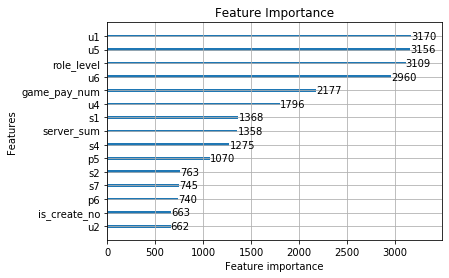

In [30]:
plt.figure(figsize=(12,6))
lgb.plot_importance(model, max_num_features=15)
plt.title('Feature Importance')
plt.show()

In [31]:
import joblib
joblib.dump(model, './xgb_model_num.m')

['./xgb_model_num.m']